# Point statistics

The `ps` (point statistics) module provides metrics to compare the mean spatial distribution of transcripts in relation to the centroid and the segmented outline of the cell. The idea of this module is to provide an intuition whether transcripts are distributed unequally, meaning they are more likely to have resulted from a spillover from neighbouring cells. The computed values can either be returned as a dictionary or stored in place in the `spatialdata` object.

**NOTE:** these metrics are still under active development and will change in upcoming releases.

To follow along with this tutorial, you can download the data from [here](https://oc.embl.de/index.php/s/1JyN4Qvk4mw0T5J).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import matplotlib.pyplot as plt
import spatialdata as sd
import spatialdata_plot  # noqa

import segtraq

# Load spatial transcriptomics dataset and initalize SegTraQ object
sdata = sd.read_zarr("../../data/xenium.zarr")
# only looking at a subset for visualization purposes
bb_xmin = 800
bb_ymin = 1150
bb_w = 200
bb_h = 300
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h
sdata = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)
# link annotations with cell boundaries
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")
st = segtraq.SegTraQ(sdata, images_key="image", tables_x_key="x_centroid", tables_y_key="y_centroid")

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:532: Fut

## Centroid mean coordinate difference

To assess the spatial distribution of a gene's transcripts within a cell, we can look at the "center of mass" of the transcripts and compare it to the centroid of the cell. 
The metric can either be computed per gene (as demonstrated below), or for all genes simultaneously (by using the `genes` argument). We compute the euclidean distance between the mean coordinate per transcript $\mu_{x,y}$ with the cell centroid coordinate $cc_{x,y}$ normalised by the cell area $|C|$. The normalisation by cell area is necessary because the computed euclidean distance scales with the cell area.

$$
d_{centroid-mean} = \frac{\sqrt{cc_{x,y}^2-\mu_{x,y}^2}}{|C|}
$$

In [3]:
# for one single gene
st.ps.centroid_mean_coord_diff("ERBB2")

cell_id  centroid_x           x   centroid_y            y    distance  \
0   apheleok-1  985.778158  985.089111  1191.758907  1192.134766  292.053855   
1   aphidfcb-1  847.440346  846.534424  1204.523379  1199.822266  502.323709   
2   aphjeaih-1  896.008961  896.242737  1176.362067  1175.994141  396.053709   
3   aphjibjb-1  902.717059  903.323486  1185.087632  1185.001953  398.843071   
4   aphjipcp-1  906.175978  907.237549  1173.395138  1175.572266  378.700703   
..         ...         ...         ...          ...          ...         ...   
72  ipocgjja-1  914.824386  910.706299  1191.846922  1193.259766  395.684610   
73  ipocjkfn-1  949.063130  952.190674  1154.533621  1152.166016  286.694002   
74  ipoclfbi-1  967.669438  968.940674  1150.176639  1151.947266  258.466231   
75  jaadeldi-1  927.709138  927.526611  1357.700496  1353.712891  605.416194   
76  jaadgjnd-1  923.959192  926.081299  1370.766188  1370.728516  630.355042   

    distance_ERBB2  
0         6.688344  
1        11.157596  
2         2.742570  
3         2.453475  
4         4.533217  
..             ...  
72        3.878958  
73        2.836878  
74        2.634063  
75        4.404448  
76        4.594937  

[77 rows x 7 columns]

This result is also stored in `spatialdata` object and accesible in the observations of the `anndata` component.

In [4]:
sdata["table"].obs[sdata["table"].obs["distance_ERBB2"].notna()].head()

cell_id  x_centroid   y_centroid  transcript_counts  \
3803  apheleok-1  985.953428  1191.931367                121   
3845  aphidfcb-1  847.619199  1204.688203                 99   
3851  aphjeaih-1  896.131162  1176.530000                452   
3855  aphjibjb-1  902.833555  1185.372773                440   
3856  aphjipcp-1  906.314512  1173.572969                265   

      control_probe_counts  genomic_control_counts  control_codeword_counts  \
3803                     0                       0                        0   
3845                     0                       1                        0   
3851                     0                       0                        0   
3855                     0                       0                        0   
3856                     0                       0                        0   

      unassigned_codeword_counts  deprecated_codeword_counts  total_counts  \
3803                           0                          21           142   
3845                           0                          27           127   
3851                           0                         106           558   
3855                           0                          78           518   
3856                           0                          44           309   

      ...  nucleus_count                                segmentation_method  \
3803  ...              1  Segmented by boundary stain (ATP1A1+CD45+E-Cad...   
3845  ...              1  Segmented by boundary stain (ATP1A1+CD45+E-Cad...   
3851  ...              1  Segmented by boundary stain (ATP1A1+CD45+E-Cad...   
3855  ...              1  Segmented by boundary stain (ATP1A1+CD45+E-Cad...   
3856  ...              1  Segmented by boundary stain (ATP1A1+CD45+E-Cad...   

      label_id           region  centroid_x           x   centroid_y  \
3803      3804  cell_boundaries  985.778158  985.089111  1191.758907   
3845      3846  cell_boundaries  847.440346  846.534424  1204.523379   
3851      3852  cell_boundaries  896.008961  896.242737  1176.362067   
3855      3856  cell_boundaries  902.717059  903.323486  1185.087632   
3856      3857  cell_boundaries  906.175978  907.237549  1173.395138   

                y    distance  distance_ERBB2  
3803  1192.134766  292.053855        6.688344  
3845  1199.822266  502.323709       11.157596  
3851  1175.994141  396.053709        2.742570  
3855  1185.001953  398.843071        2.453475  
3856  1175.572266  378.700703        4.533217  

[5 rows x 22 columns]

We can visualise these results in space for the gene ERBB2

In [5]:
sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][sdata_plot["table"].obs["distance_ERBB2"].notna()]

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     input has more than 103 categories. Uniform 'grey' color will be used for all categories.                 


/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", Implici

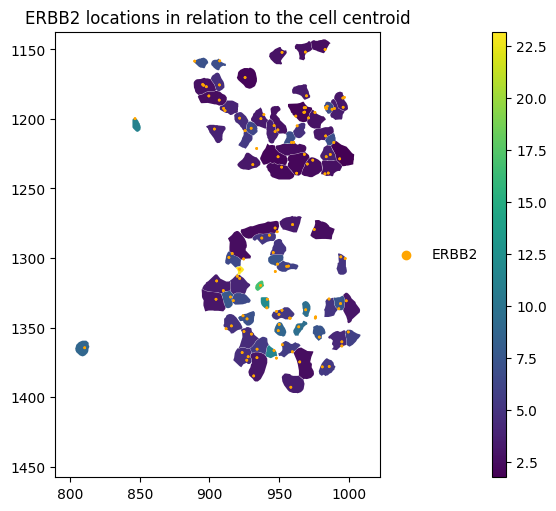

In [6]:
sdata_plot.pl.render_shapes(
    "cell_boundaries",
    color="distance_ERBB2",
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups="ERBB2",
    palette="orange",
).pl.show(
    title="ERBB2 locations in relation to the cell centroid",
    coordinate_systems="global",
    figsize=(10, 5),
)

We notice that there are some cells with a lot of cells at the boundary and some others that are more balanced.

## Distance to membrane

Another way to look at the spatial distribution of transcripts is the distance of a gene's transcripts to the membrane. In some sense, this is complementary to the `centroid_mean_coord_diff` metric. However, in the case of very irregularly shaped cells, the distance to the membrane is a more direct measure of unequal transcript distribution and hence potential spillover.  

The metric is defined as the mean distance to the cell membrane $\mu(d(m,t))$ (as provided in the `spatialdata` object) divided by the cell area $|C|$.
Again, this can be applied either to specific genes or all genes simultaneously.

$$
d_{membrane} = \frac{\mu(d(m,t))}{|C|}
$$

In [7]:
st.ps.distance_to_membrane("ERBB2")

cell_id  distance_to_outline_ERBB2   cell_area  \
0   apheleok-1                   1.002028   43.666095   
1   aphidfcb-1                   0.046875   45.020783   
2   aphjeaih-1                   4.259394  144.409693   
3   aphjibjb-1                   3.361656  162.562506   
4   aphjipcp-1                   3.252922   83.539066   
..         ...                        ...         ...   
72  ipocgjja-1                   1.651899  102.007972   
73  ipocjkfn-1                   1.841699  101.059691   
74  ipoclfbi-1                   1.104993   98.124535   
75  jaadeldi-1                   1.513872  137.455630   
76  jaadgjnd-1                   2.240920  137.184692   

    distance_to_outline_inverse_ERBB2  
0                            0.998988  
1                            4.618802  
2                            0.484536  
3                            0.545410  
4                            0.554451  
..                                ...  
72                           0.778051  
73                           0.736870  
74                           0.951306  
75                           0.812747  
76                           0.668016  

[77 rows x 4 columns]

Also this result is also stored in spatialdata object and accesible in the observations of the anndata component.

In [8]:
sdata["table"].obs[
    sdata["table"].obs["distance_to_outline_ERBB2"].notna()
    | sdata["table"].obs["distance_to_outline_inverse_ERBB2"].notna()
]

cell_id  x_centroid   y_centroid  transcript_counts  \
3803   apheleok-1  985.953428  1191.931367                121   
3845   aphidfcb-1  847.619199  1204.688203                 99   
3851   aphjeaih-1  896.131162  1176.530000                452   
3855   aphjibjb-1  902.833555  1185.372773                440   
3856   aphjipcp-1  906.314512  1173.572969                265   
...           ...         ...          ...                ...   
15354  ipocgjja-1  914.939512  1191.996797                285   
15357  ipocjkfn-1  949.197324  1154.718477                282   
15358  ipoclfbi-1  967.801328  1150.317109                254   
15762  jaadeldi-1  927.810605  1357.838594                406   
15763  jaadgjnd-1  924.104795  1370.922578                341   

       control_probe_counts  genomic_control_counts  control_codeword_counts  \
3803                      0                       0                        0   
3845                      0                       1                        0   
3851                      0                       0                        0   
3855                      0                       0                        0   
3856                      0                       0                        0   
...                     ...                     ...                      ...   
15354                     0                       0                        0   
15357                     0                       0                        0   
15358                     0                       0                        0   
15762                     0                       0                        0   
15763                     0                       0                        0   

       unassigned_codeword_counts  deprecated_codeword_counts  total_counts  \
3803                            0                          21           142   
3845                            0                          27           127   
3851                            0                         106           558   
3855                            0                          78           518   
3856                            0                          44           309   
...                           ...                         ...           ...   
15354                           0                          46           331   
15357                           0                          66           348   
15358                           0                          46           300   
15762                           0                          46           452   
15763                           0                          66           407   

       ...  label_id           region  centroid_x           x   centroid_y  \
3803   ...      3804  cell_boundaries  985.778158  985.089111  1191.758907   
3845   ...      3846  cell_boundaries  847.440346  846.534424  1204.523379   
3851   ...      3852  cell_boundaries  896.008961  896.242737  1176.362067   
3855   ...      3856  cell_boundaries  902.717059  903.323486  1185.087632   
3856   ...      3857  cell_boundaries  906.175978  907.237549  1173.395138   
...    ...       ...              ...         ...         ...          ...   
15354  ...     15355  cell_boundaries  914.824386  910.706299  1191.846922   
15357  ...     15358  cell_boundaries  949.063130  952.190674  1154.533621   
15358  ...     15359  cell_boundaries  967.669438  968.940674  1150.176639   
15762  ...     15763  cell_boundaries  927.709138  927.526611  1357.700496   
15763  ...     15764  cell_boundaries  923.959192  926.081299  1370.766188   

                 y    distance  distance_ERBB2  distance_to_outline_ERBB2  \
3803   1192.134766  292.053855        6.688344                   1.002028   
3845   1199.822266  502.323709       11.157596                   0.046875   
3851   1175.994141  396.053709        2.742570                   4.259394   
3855   1185.001953  398.843071        2.453475                   3.361656 

We can also plot this metric in space.

INFO     input has more than 103 categories. Uniform 'grey' color will be used for all categories.                 


/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.


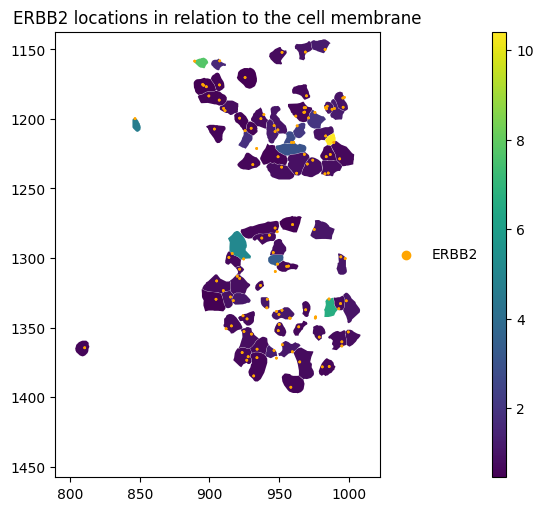

In [9]:
sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][sdata_plot["table"].obs["distance_to_outline_inverse_ERBB2"].notna()]

sdata_plot.pl.render_shapes(
    "cell_boundaries",
    color="distance_to_outline_inverse_ERBB2",
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups="ERBB2",
    palette="orange",
).pl.show(
    title="ERBB2 locations in relation to the cell membrane",
    coordinate_systems="global",
    figsize=(10, 5),
)

We note that the two metrics are complementary to each other. However, there are situations with irregularly shaped cells where the distance to the centroid might be very small although the transcripts are clearly on the boarder of the cell.

## Periphery Enrichment Score

We can also compute the periphery enrichment score. For each cell, we divide the cell into an outer halo (erosion by 30% of the radius) and an inner part. We then aggregate all genes, and count how many transcripts we see on the inner vs. outer part. Both of these then are divided by their area to get the density. The rationale is, that a higher density of transcripts in the outer region could be due to spillover. Finally, we take the ratio of the border density vs. the inner density. If this is 1, our densities are equal. A value below one indicates a higher concentration of transcripts in the nucleus, whereas a value above one indicates higher transcript density in the outer region of the cell. This can be computed for individual genes as well as all genes (with the `genes` argument).

To avoid division by 0, pseudocounts are added if there is at least 1 transcript assigned to the cell. If both the border and the center expression are 0, we set the density ratio to NaN.

In [10]:
# the score we are interested in here is the "density_ratio"
periphery_df = st.ps.periphery_enrichment_score("ERBB2")
periphery_df.head()

cell_id  center_expr_ERBB2  border_expr_ERBB2  center_area_ERBB2  \
0  aphcnklp-1                  0                  0          23.560789   
1  aphdnoam-1                  0                  0          12.014023   
2  aphdpfhl-1                  0                  0          37.536276   
3  aphebebn-1                  0                  0          77.656057   
4  aphejokb-1                  0                  0          36.136216   

   border_area_ERBB2  border_density_ERBB2  center_density_ERBB2  \
0          26.720265              0.037425              0.042443   
1          15.191087              0.065828              0.083236   
2          52.482329              0.019054              0.026641   
3         101.160773              0.009885              0.012877   
4          49.975528              0.020010              0.027673   

   density_ratio_ERBB2  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN

INFO     input has more than 103 categories. Uniform 'grey' color will be used for all categories.                 


/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.


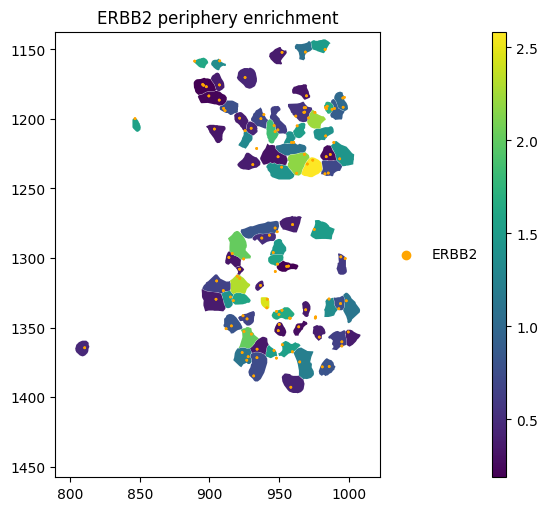

In [11]:
sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][sdata_plot["table"].obs["density_ratio_ERBB2"].notna()]

sdata_plot.pl.render_shapes(
    element="cell_boundaries",
    color="density_ratio_ERBB2",
    cmap="viridis",
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups="ERBB2",
    palette="orange",
).pl.show(
    title="ERBB2 periphery enrichment",
    coordinate_systems="global",
    figsize=(10, 5),
)

## Comparing the three metrics

Let's look at all three metrics right next to one another. We will only consider the metrics computed on all transcripts here, and not look at individual genes.

In [12]:
_ = st.ps.centroid_mean_coord_diff()
_ = st.ps.distance_to_membrane()
_ = st.ps.periphery_enrichment_score()

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_centers` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_borders` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._c

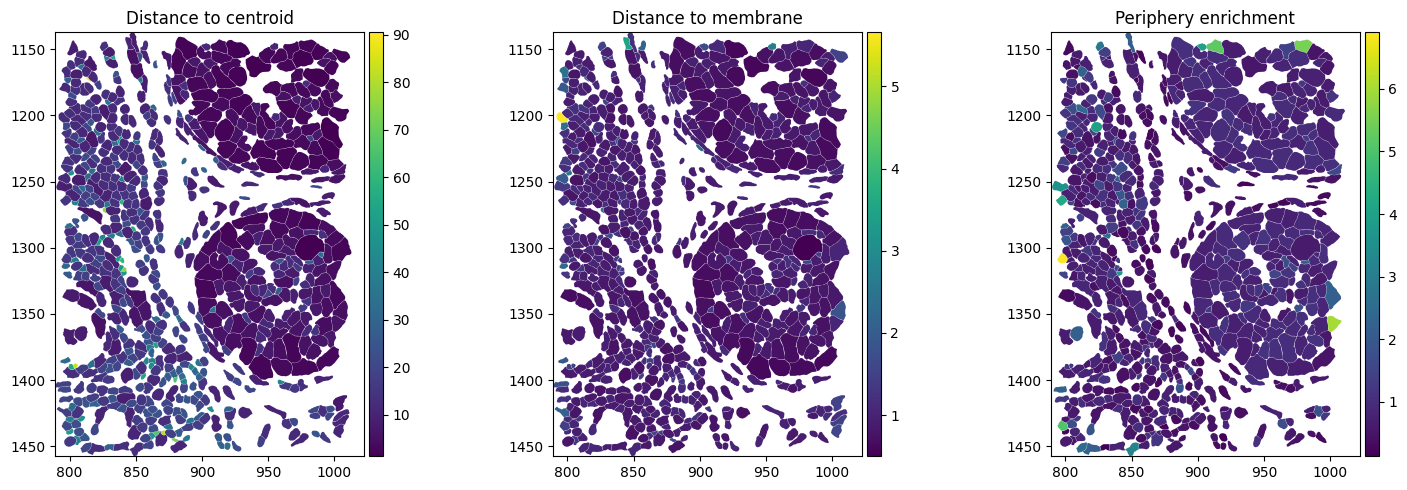

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# periphery enrichment
sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][sdata_plot["table"].obs["distance_all_genes"].notna()]
sdata_plot.pl.render_shapes(
    element="cell_boundaries",
    color="distance_all_genes",
).pl.show(
    title="Distance to centroid",
    coordinate_systems="global",
    ax=ax[0],
)

# periphery enrichment
sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][sdata_plot["table"].obs["distance_to_outline_inverse_all_genes"].notna()]
sdata_plot.pl.render_shapes(
    element="cell_boundaries",
    color="distance_to_outline_inverse_all_genes",
).pl.show(
    title="Distance to membrane",
    coordinate_systems="global",
    ax=ax[1],
)

# periphery enrichment
sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][sdata_plot["table"].obs["density_ratio_all_genes"].notna()]
sdata_plot.pl.render_shapes(
    element="cell_boundaries",
    color="density_ratio_all_genes",
).pl.show(
    title="Periphery enrichment",
    coordinate_systems="global",
    ax=ax[2],
)

plt.tight_layout()